### Plan of attack
1. Parse in the data
2. Split into training, dev/val, and test
3. Sketch out model architecture
4. Make a forward pass
5. Make a backward pass
6. Profit

In [197]:
%pip install -q tqd
%pip install -q scikit-learn

ERROR: Could not find a version that satisfies the requirement tqd (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for tqd
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [198]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

## Parse the data

In [199]:
with open('names.txt') as file: 
    names = file.read().splitlines()

In [200]:
special_char = '.'

lookup = sorted(set("".join(names) + special_char))

def stoi(c):
    return lookup.index(c)

def itos(i): 
    return lookup[i]

In [201]:
X = []
Y = []

window = 3

for name in names:
    # note: don't want multiple special characters at the end -- just one!
    context = special_char * window + name + special_char 

    for i in range(len(context) - window):
        x = [stoi(c) for c in context[i:i + window]]
        X.append(x)
        Y.append(stoi(context[i + window]))
        # print(f"{context[i:i + window]} -> {context[i + window]}")
    
    # break

In [202]:
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [203]:
### Split datasets

In [337]:
n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0)
Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)

Xtr.shape, Xdev.shape, Xts.shape, Ytr.shape, Ydev.shape, Yts.shape

(torch.Size([182516, 3]),
 torch.Size([22815, 3]),
 torch.Size([22815, 3]),
 torch.Size([182516]),
 torch.Size([22815]),
 torch.Size([22815]))

## Create embeddings

In [356]:
g = torch.Generator().manual_seed(2147483647) # Karpathy's seed

In [609]:
n_chars = len(lookup)
n_dims = 10

C = torch.randn((n_chars, n_dims), generator=g)

### sanity check

In [681]:
ch = X[5, 0]
ch, C[ch] 

(tensor(0),
 tensor([ 0.3383, -0.2996,  0.2168,  0.4223,  0.4427, -0.3429,  0.9060, -0.2743,
         -0.1121, -0.1530], grad_fn=<SelectBackward0>))

In [731]:
# sanity check
F.one_hot(X[5, 0], num_classes=27).float() @ C

tensor([ 0.1829, -0.0745, -0.0532, -0.0384, -0.0418,  0.0522, -0.0640, -0.0023,
        -0.0004, -0.0362], grad_fn=<SqueezeBackward4>)

## Defining model architecture

In [748]:
n_input = window * n_dims # the number of chars used * dimensions per each
n_hidden = 200

kaiming =  (5/3) / (n_input ** 0.5)
C = torch.randn((n_chars, n_dims), generator=g) * 0.1 #FIXME: for some reason, this is needed to squish the tanh initially
W1 = torch.randn((n_input, n_hidden) ,generator=g) * kaiming # He initialization 
b1 = torch.randn(n_hidden, generator=g) * 0.01        
W2 = torch.randn((n_hidden, n_chars), generator=g) * 0.01 #makes the loss not look a hockey stick
b2 = torch.randn(n_chars, generator=g) * 0

W1.shape, b1.shape, W2.shape, b2.shape

(torch.Size([30, 200]),
 torch.Size([200]),
 torch.Size([200, 27]),
 torch.Size([27]))

In [749]:
b2.dtype

torch.float32

In [750]:
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

11897

In [751]:
# manually implement the loss

# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True) # have to sum across the specific axis

# probs[0, Y[0]] -> correct for first row 
# probs[Y] -> incorrect because takes the entire probability row out for each letter index, not what i want

# likelihoods = probs[torch.arange(probs.shape[0]), Y]
# assert probs[0, Y[0]] == likelihoods[0]

# loss = -likelihoods.log().mean()
# loss

## Training

In [752]:
h = None
input = None
L1 = None

def forward(X): 
    global h, input, L1
    # forward pass
    emb = C[X] # (batch_size, window, n_dims)
    input = emb.view(emb.shape[0], -1) # (batch_size, n_input)
    # input2 = emb.view(-1, n_dims * window) # (batch_size, n_input)

    L1 = input @ W1 + b1
    h = torch.tanh(L1) # NB! missed the activation function!
    logits = h @ W2 + b2  

    return logits # (batch_size, n_chars)

### Find the optimal lr

In [753]:
# n_iterations = 1000

# lre = torch.linspace(-3, 0, n_iterations)
# lrs = 10 ** lre
# lri = []
# lossi = []

# for i in range(n_iterations): 
#     # batching 
#     ix = torch.randint(0, Xtr.shape[0], (32,)) # 32 is the batch size

#     logits = step(Xtr[ix])
#     loss = F.cross_entropy(logits, Ytr[ix]) #NB! this has to be the raw logits! 

#     for p in parameters: 
#         p.grad = None

#     loss.backward()

#     lr = lrs[i] 
#     for p in parameters: 
#         p.data -= lr * p.grad

#     lri.append(lr)
#     lossi.append(loss.item())

# # why is this actually reliable? 
# # wouldn't the loss naturally decrease with time? 
# px.scatter(
#     x=lri,
#     y=lossi,
#     labels={'x': 'LR', 'y': 'Loss'},
#     trendline='lowess'
# )

### loop

In [754]:
lossi = []
lossdevi = []
stepi = []

total = 0

In [755]:
n_epochs = 50
batch_size = 32

for i in tqdm(range(n_epochs)): 
    # evaluate dev loss
    # logits = forward(Xdev)
    # loss = F.cross_entropy(logits, Ydev)
    # lossdevi.append(loss.item())
    
    permutation = torch.randperm(Xtr.shape[0], generator=g)
    # batching 
    for j in range(0, len(permutation), batch_size):
        ix = permutation[j:j + batch_size]  

        logits = forward(Xtr[ix])
        loss = F.cross_entropy(logits, Ytr[ix]) #NB! this has to be the raw logits! 

        for p in parameters: # zero grad!
            p.grad = None

        loss.backward()

        lr = 0.1 if i < n_epochs / 2 else 0.01
        # lr = 10 ** (-(total * 2 / 100000 + 1))

        for p in parameters: 
            p.data -= lr * p.grad

        lossi.append(loss.log10().item())
        stepi.append(total)
        total += 1


# messy because of mini-batching ! 
px.scatter(
    x=stepi,
    y=lossi,
    labels={'x': 'Step', 'y': 'Loss'},
    title='Loss over time',
)

# TODO: interesting to see a small 'step down' in the above as the learning rate is swapped for a finer one. why is this? 


100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


### testing saturations of tan activation layer

(array([0.12039262, 0.12039262, 0.24078524, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.12039262, 0.24078524,
        0.        , 0.12039262, 0.12039262, 0.12039262, 0.72235571,
        0.12039262, 0.36117785, 0.60196309, 0.60196309, 0.48157047,
        0.96314094, 1.08353356, 0.72235571, 0.60196309, 0.60196309,
        1.68549665, 1.80588927, 1.92628189, 0.84274833, 1.56510403,
        0.84274833, 1.20392618, 0.48157047, 0.60196309, 0.60196309,
        0.72235571, 0.36117785, 0.84274833, 0.36117785, 0.36117785,
        0.24078524, 0.24078524, 0.84274833, 0.        , 0.24078524,
        0.        , 0.12039262, 0.        , 0.        , 0.12039262]),
 array([-1.12795401, -1.08642322, -1.04489244, -1.00336165, -0.96183086,
        -0.92030008, -0.87876929, -0.83723851, -0.79570772, -0.75417694,
        -0.71264615, -0.67111537, -0.62958458, -0.58805379, -0.54652301,
        -0.50499222, -0.46346144, -0.42193065, -0.38039987, -0.33886908,
        -0.29733829, -0.25

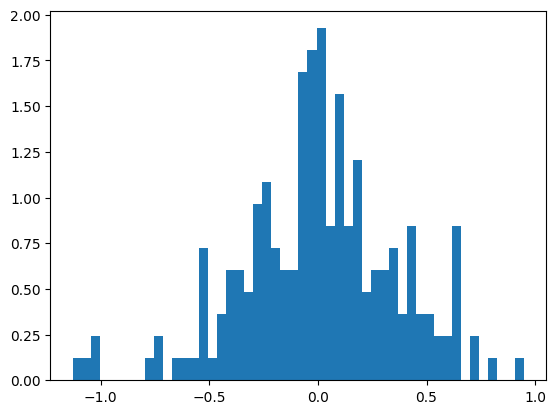

In [756]:
plt.hist(b1.tolist(), bins=50, density=True)

(array([0.0023256 , 0.        , 0.        , 0.0046512 , 0.0046512 ,
        0.0093024 , 0.02325601, 0.03720961, 0.03023281, 0.04651201,
        0.05581442, 0.07674482, 0.08837283, 0.10232643, 0.20000166,
        0.22558327, 0.29302569, 0.38139852, 0.41628253, 0.50465535,
        0.57907458, 0.59070258, 0.69302901, 0.79768104, 0.83256505,
        0.87675147, 0.95582189, 0.85116986, 0.83721626, 0.74419223,
        0.63488899, 0.56744657, 0.57674898, 0.36046811, 0.29070009,
        0.27442088, 0.23488567, 0.20465286, 0.16279205, 0.10465203,
        0.09069843, 0.05348882, 0.03488401, 0.03023281, 0.02558161,
        0.02325601, 0.0093024 , 0.0046512 , 0.0069768 , 0.0023256 ]),
 array([-1.85889566, -1.78722959, -1.71556352, -1.64389745, -1.57223137,
        -1.5005653 , -1.42889923, -1.35723316, -1.28556709, -1.21390102,
        -1.14223495, -1.07056887, -0.9989028 , -0.92723673, -0.85557066,
        -0.78390459, -0.71223852, -0.64057245, -0.56890637, -0.4972403 ,
        -0.42557423, -0.35

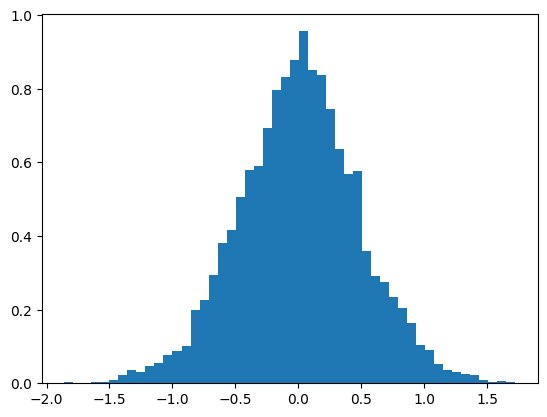

In [757]:
plt.hist(W1.view(-1).tolist(), bins=50, density=True)

(array([0.03844975, 0.01922487, 0.        , 0.        , 0.03844975,
        0.0768995 , 0.26914825, 0.09612437, 0.05767462, 0.03844975,
        0.        , 0.        , 0.153799  , 0.26914825, 0.307598  ,
        0.        , 0.21147362, 0.21147362, 0.307598  , 0.17302387,
        0.03844975, 0.67287062, 0.19224875, 1.40341586, 0.92279399,
        0.17302387, 0.24992337, 1.80713823, 0.21147362, 0.36527262,
        0.3844975 , 0.307598  , 0.65364574, 0.17302387, 0.28837312,
        0.19224875, 0.19224875, 0.153799  , 0.21147362, 0.28837312,
        0.        , 0.03844975, 0.13457412, 0.01922487, 0.05767462,
        0.        , 0.        , 0.03844975, 0.        , 0.09612437]),
 array([-2.20136046, -2.11466722, -2.02797399, -1.94128075, -1.85458751,
        -1.76789427, -1.68120103, -1.59450779, -1.50781455, -1.42112131,
        -1.33442807, -1.24773483, -1.16104159, -1.07434835, -0.98765512,
        -0.90096188, -0.81426864, -0.7275754 , -0.64088216, -0.55418892,
        -0.46749568, -0.38

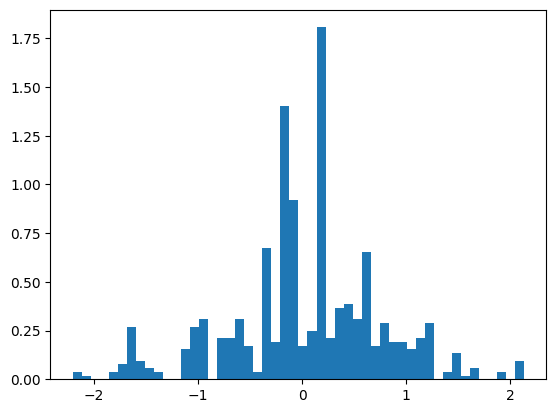

In [758]:
plt.hist(input.view(-1).tolist(), bins=50, density=True)

(array([0.00073848, 0.        , 0.        , 0.00073848, 0.00073848,
        0.00221545, 0.00295393, 0.0044309 , 0.00516938, 0.00516938,
        0.00738484, 0.00516938, 0.01107725, 0.02436996, 0.02215451,
        0.03470873, 0.03987811, 0.05907868, 0.0583402 , 0.07163291,
        0.07975622, 0.0945259 , 0.11077253, 0.16542032, 0.18166696,
        0.2651156 , 0.40911989, 0.24665351, 0.17871302, 0.15951245,
        0.14400429, 0.11889585, 0.08271016, 0.07975622, 0.0627711 ,
        0.03840115, 0.03618569, 0.03175479, 0.03470873, 0.01772361,
        0.01772361, 0.01255422, 0.00738484, 0.00516938, 0.00369242,
        0.00295393, 0.00664635, 0.00147697, 0.00073848, 0.00147697]),
 array([-8.96739674, -8.62886517, -8.2903336 , -7.95180202, -7.61327045,
        -7.27473888, -6.93620731, -6.59767574, -6.25914417, -5.9206126 ,
        -5.58208103, -5.24354946, -4.90501789, -4.56648632, -4.22795475,
        -3.88942318, -3.55089161, -3.21236004, -2.87382847, -2.5352969 ,
        -2.19676533, -1.85

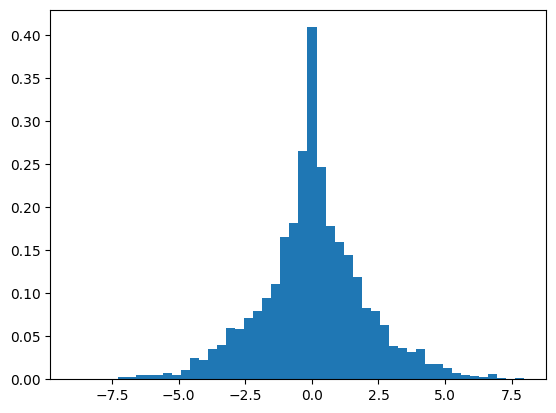

In [759]:
plt.hist(L1.view(-1).tolist(), bins=50, density=True)

(array([3.56250042, 0.74375009, 0.57500007, 0.44375005, 0.44375005,
        0.37500004, 0.38125005, 0.38750005, 0.30625004, 0.28125003,
        0.33750004, 0.18750002, 0.25000003, 0.28125003, 0.28125003,
        0.26875003, 0.26250003, 0.26875003, 0.37500004, 0.29375004,
        0.32500004, 0.42500005, 0.37500004, 0.41875005, 0.40625005,
        0.50000006, 0.42500005, 0.46875006, 0.31250004, 0.38125005,
        0.36875004, 0.36250004, 0.20000002, 0.25000003, 0.23125003,
        0.18125002, 0.25000003, 0.27500003, 0.28750003, 0.25000003,
        0.27500003, 0.31250004, 0.31250004, 0.35625004, 0.38750005,
        0.52500006, 0.59375007, 0.68125008, 1.03125012, 3.52500042]),
 array([-1.00000000e+00, -9.60000005e-01, -9.20000010e-01, -8.80000014e-01,
        -8.40000019e-01, -8.00000024e-01, -7.60000029e-01, -7.20000033e-01,
        -6.80000038e-01, -6.40000043e-01, -6.00000048e-01, -5.60000052e-01,
        -5.20000057e-01, -4.80000062e-01, -4.40000067e-01, -4.00000072e-01,
        -3.600

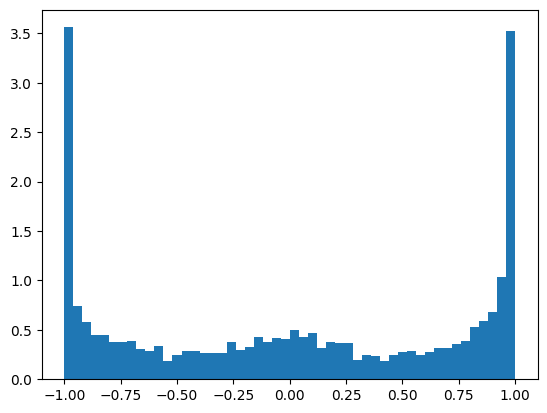

In [765]:
plt.hist(h.view(-1).tolist(), bins=50, density=True)

In [761]:
# TODO: do i want these 'empty' examples? 
Xdev[19], Ydev[19]

(tensor([0, 0, 0]), tensor(1))

In [766]:
# Calculate the percentage of values > 0.99 for each row
saturation_percentage = (h[:100].abs() > 0.99).float().mean(dim=1)

# Find indices where less than 20% of values are > 0.99 (i.e., 80%+ are <= 0.99)
low_saturation_indices = torch.where(saturation_percentage < 0.1)[0]

low_saturation_indices, Xdev[low_saturation_indices], Ydev[low_saturation_indices]

(tensor([ 2,  3,  5,  8, 10, 16]),
 tensor([[26, 21,  8],
         [21,  8,  1],
         [ 1,  9,  2],
         [ 0, 26, 21],
         [21, 18,  9],
         [26, 25, 12]]),
 tensor([ 1,  9,  0, 18,  3,  5]))

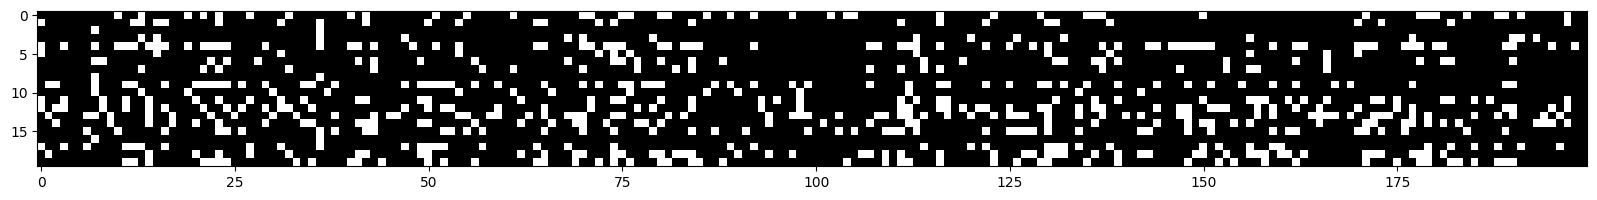

In [763]:
plt.figure(figsize=(20, 10))
plt.imshow(h[:100].abs() > 0.99, cmap='gray', interpolation='nearest')

# why does the above follow some sort of pattern? is it the '...' examples at the beginning of each sample? 
# it seems to indeed be those examples with identical inputs that produce these patterns.

## Evaluate performance

In [767]:
px.scatter(
    x=range(len(lossdevi)),
    y=lossdevi,
    trendline='lowess'
)


ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

In [768]:
with torch.no_grad():
    logits = forward(Xtr)
    loss = F.cross_entropy(logits, Ytr)

loss

tensor(1.9853)

In [769]:
with torch.no_grad():
    logits = forward(Xdev)
    loss = F.cross_entropy(logits, Ydev)

loss

tensor(2.3207)

If both losses are roughly equal, the network is likely underfitting. Once the training loss starts to sink below the dev loss, we are probably overfitting.

## Generate by forward pass

In [680]:
g = torch.Generator().manual_seed(2147483647 + 10) # I suppose this is so that the generation is out of sample/different from the training one

def gen(seed):
    x = [stoi(ch) for ch in seed[-window:]]

    x = torch.tensor(x)

    logits = forward(x)
    probs = F.softmax(logits, dim=1) 
    next = torch.multinomial(probs, num_samples=1).item()

    ch = itos(next)
    seed += ch

    return seed


In [126]:
seed = special_char * window 

for i in range(10):
    while True:
        seed = gen(seed)
        if seed[-1] == special_char:
            print(seed)
            seed = special_char * window
            break


...uri.
...imberlynned.
...uriyah.
...ulde.
...usminitha.
...uleenacons.
...udicolly.
...ullli.
...uri.
...us.


### Question: does increasing the window size prevent super-long names that seemingly occured previously? 

Hypothesis: yes, because the model takes into account that if the past five letters are all chars, a dot is more likely. With three letters, there are a lot more examples where three chars =/= dot is more likely since the name is not ending yet.

Test plan: generate a bunch of random samples of names after the model has been trained and compare the distribution of name lengths. 

## Visualize vector embeddings

### 2D

In [149]:
every = [stoi(ch) for ch in lookup]
every = torch.tensor(every)

embds = C[every].data
# px.scatter(df, x=0, y=1, text=lookup, title='Character embeddings', size_max=15, size=[1] * len(df))


### PCA (any N dimensions)

In [150]:
from sklearn.preprocessing import StandardScaler

# WOW! This step made a pretty huge difference on the PCA visualization!
scaler = StandardScaler()
embds_scaled = scaler.fit_transform(embds)
 
embds[:3], embds_scaled[:3] # maintain proportion to each other within, but are now globally scaled across

(tensor([[ 0.4297, -0.0778,  0.1628,  0.0520,  0.3370, -0.0216, -0.3438,  0.0244,
           0.0975,  0.1927],
         [-0.4297,  0.8287, -0.1094, -0.2271,  0.9935,  1.6836,  0.7888, -0.7836,
           0.4301, -0.7509],
         [ 1.2031,  0.3165, -1.8722,  0.5098, -0.8355,  2.1910,  3.1477, -0.5378,
          -1.4214,  1.6220]]),
 array([[ 0.74885418, -0.33464207,  0.68191355,  0.02397854,  0.88530027,
         -0.0854077 , -0.77023671, -0.20516099,  0.29100489,  0.15257031],
        [ 0.0070228 ,  0.60097728,  0.40134437, -0.25486847,  1.54944899,
          1.66387014,  0.30341561, -0.88177875,  0.58597   , -0.81865177],
        [ 1.41645395,  0.07228041, -1.4149876 ,  0.48132767, -0.30106928,
          2.1844049 ,  2.5396711 , -0.6759382 , -1.05588399,  1.62371062]]))

In [151]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embds = pca.fit_transform(embds_scaled)
px.scatter(pca_embds, x=0, y=1, text=lookup, title='Character embeddings', size_max=15, size=[1] * len(embds))

In [147]:
pca.explained_variance_ratio_

array([0.43961654, 0.29166571])

## Ideas to optimize loss
0. Default                                          | loss = 2.4434
1. Mini-batching while iterating over everything    | loss = 2.4384 (after running the loop twice, i.e. didn't seem to have much effect probably cuz of law of large numbers)
2. Larger hidden layer                              | loss_200 = 2.4335, loss_300 = 2.4540 
2.5 Keeping track of the min_loss on the dev set every epoch | didn't help much either, basically the same as in the final step of training (~2.45)
* fixed setting lr to smaller based on epoch_i, that (seemed to have) helped get ~2.36

NB! Ignore all of the above. Few bugs were fixes:
- initializing W2 layer with rand instead of randn
- not resetting the C embedding matrix after training loops for different models

seem to be getting roughly 2.5 now no matter what -> why not equal to / lower than Antony's? 

3. More vector embedding dimensions
    -> meh, still 2.4469

2.4243 is lowest so far

2.3806 with slightly nudging up the batch size, and training for longer, as well as a 4-char context window!!

4. Use a larger context window
5. Regularization!!

## V2
| Variant | Loss |
| --- | --- |
| Default (window=3, n_dims=3, batch_size=32, n_epochs=50, lr drops halfway) | 2.4152 |  (note: did not use torch.generator for this properly)
| Fix init. random weights (hockey stick) | 2.3708 |
| Kaiming init + (C emb * 0.1) + n_dims=10 | 2.3207 |